Questions:
- Set a seed ✓
- Read data ✓
- Check nulls ✓
- How many users? ✓
- How many categories? ✓
    - How much records does each one have? ✓
- How many posts? ✓
- How many interactions? ✓
- What is the average interactions per post? ✓
- Remove "insignificant" connections. ✓
- How representative was the reduction? ✓
- Create a reasonable visualization from the graph (e.g. Gephi)
- Create a mapping from all names to indices (e.g. LabelEncoder). How to get all names? ✓
- Create a mapping from all labels to an indices. ✓
- Create a mapping from all nodes to a label index. ✓
- Create a toy model (e.g. the GCN example provided in the documentation). ✓
- Check if the data object was created correctly. 
- Define the embedding dimension.
- Create and save a [Node2Vec](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.models.Node2Vec) model. ✓
- Create and save a [GCN](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) model. ✓
- Create ans save a [GAT](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv) model. ✓
- Create ans save a [SAGE](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.SAGEConv) model.
- Create ans save a [GIN](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GINConv) model.
- Use a t-SNE and plot the classes with different colors.
- How consistent are the embeddings? 
- Do they group well together?
- From which models does the greatest embeddings come from?
- Which metric will be optimized by the learning models?
- Which model should be used to classify the nodes?
    - If a neural model:
        - Which learning rate? Is it adaptive? 
        - How many epochs? 
        - Which architecture?
        - Present a training erro vs test error analysis chart.
- Which categories reach the greatest performance? 
    - Why?
    - Is there any pausible reason or maybe characteristic from a method/family of methods that helps to perform better in our case? If so, what is?
- 
   
Resources:
- https://graphreason.github.io/papers/39.pdf (Must Read)
- https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8
- https://pytorch-geometric.readthedocs.io/

In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import plotly.graph_objects as go
import os

from sklearn.model_selection import StratifiedKFold
from torch_geometric.data import Data
from torch.utils.data import DataLoader
from torch_geometric.nn.models import Node2Vec
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv
from torch.optim import Adam
from torch.nn import NLLLoss
from collections import defaultdict

In [ ]:
profiles.isna().sum()

In [ ]:
comments.isna().sum()

In [ ]:
results = profiles.category_1.value_counts()

figure = go.Figure(
    data=[go.Pie(labels=results.index.values, values=results.values)],
    layout_title_text="Percentage of Each Category"
)

figure.show()

In [ ]:
category_to_index = {category: index for index, category in enumerate(results.index)}
profiles.category_1 = profiles.category_1.map(lambda key: category_to_index[key])
profiles.head(3)

In [ ]:
known_users = profiles.profile_username.unique().tolist()
followers = comments.commenter.unique().tolist()
prev_number_of_users = len(set(known_users + followers))

print("There are originally {} users".format(prev_number_of_users))

In [ ]:
all_posts = len(comments.media_short_code.unique())
all_interactions = len(comments)
print("There are {} distinct posts and {} interactions. An average of {} interactions per post"\
          .format(all_posts, all_interactions, np.round(all_interactions/all_posts, 2)))

In [ ]:
RELEVANCE_THRESHOLD = 50
subgraph = []

action_authors = pd.concat([comments.commenter.value_counts(), comments.media_author.value_counts()])
action_authors = action_authors.groupby(action_authors.index).agg("sum")
for commenter, frequency in action_authors.items():
    if (frequency > RELEVANCE_THRESHOLD) or (commenter in known_users):
        subgraph.append(commenter)
        
comments = comments[comments.commenter.isin(subgraph)]

In [ ]:
known_users = profiles.profile_username.unique().tolist()
followers = comments.commenter.unique().tolist()
all_users = set(known_users + followers)
cur_number_of_users = len(all_users)

print("The new graph drawn from relevance threshold {} has {} users and {} interactions"\
          .format(RELEVANCE_THRESHOLD, cur_number_of_users, len(comments)))

In [ ]:
print("The number of users was reduced by ~ {}%"\
          .format(np.round(1-cur_number_of_users/prev_number_of_users, 2) * 100))

In [ ]:
profiles.head(1)

In [1]:
import pandas as pd
import numpy as np
import torch
import preprocessing
import utils

from sklearn.model_selection import StratifiedKFold
from torch_geometric.data import Data
from collections import defaultdict

torch.manual_seed(0)
np.random.seed(0)

profiles = pd.read_csv("../data/profiles.csv", usecols=["profile_username", "profile_followed_by", "profile_follow", 
                                                        "medias_nb", "comments_nb", "comments_commenters_nb", 
                                                        "comments_self_nb", "category_1"])
comments = pd.read_csv("../data/comments.csv", usecols=["media_short_code", "media_author", "commenter"])

profiles = preprocessing.categorical_to_numerical(profiles, col="category_1")
comments = comments.drop_duplicates()
comments = preprocessing.filter_by_relevance(comments, profiles, minimum_freq=50)

known_users = profiles.profile_username.unique().tolist()
followers = comments.commenter.unique().tolist()
all_users = set(known_users + followers)

names = profiles.profile_username.values
data = profiles[["profile_followed_by", "profile_follow", "medias_nb", 
                "comments_nb", "comments_commenters_nb", "comments_self_nb"]].values
name_to_record = {name: record for name, record in zip(names, data)}

input_dim, output_dim = data.shape[1], len(profiles.category_1.unique()) + 1
user_to_label = {user: category for user, category in profiles[["profile_username", "category_1"]].values}

In [2]:
def update_histories(models_histories, new_histories):
    for model, history in new_histories.items():
        if not models_histories[model]:
            models_histories[model] = np.array(new_histories[model])
        else:
            models_histories[model] += np.array(new_histories[model])
    
    return models_histories
    

def calculate_statistics(models_metrics):
    return {model: {metric: (np.mean(values), np.std(values)) for metric, values in metrics.items()} 
                for model, metrics in models_metrics.items()}

In [53]:
K = 5
skf = StratifiedKFold(n_splits=K)

n_hidden_units = 64
print("Fez of preprocessamento")
models_metrics = defaultdict(dict)
models_histories = defaultdict(list)
for train_idx, test_idx in skf.split(profiles.profile_username.values, profiles.category_1.values):
    train_authors, test_authors = utils.get_authors(profiles, all_users, train_idx, test_idx)

    print("Pegou autores")

    username_to_index = utils.get_users_indices(train_authors)
    print("Pegou indices")
    train_interactions = utils.get_interactions(comments[(comments.media_author.isin(train_authors)) 
                                                    & (comments.commenter.isin(train_authors))], username_to_index)
    print("Pegou interações")
    x_train, y_train = utils.get_x(train_authors, name_to_record, input_dim=input_dim), utils.get_y(user_to_label, train_authors)
    print("Pegou x e y")
    assert len(x_train)==len(y_train), "Train Input and Output tensor do not have the same dimensions"


    edge_index = utils.get_edge_index(train_interactions)
    print("Pegou os indices de arestas")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = Data(x=x_train, y=y_train, edge_index=edge_index).to(device)
    print("Criou Data")

    models = utils.get_models(data.num_nodes, input_dim, output_dim, n_hidden_units, device=device, lr=0.005)
    print("Criou modelos")

    histories = utils.train(data, models, epochs=1)
    models_histories = update_histories(models_histories, histories)

    username_to_index = utils.get_users_indices(test_authors)
    test_interactions = utils.get_interactions(comments[(comments.media_author.isin(test_authors)) 
                                                    & (comments.commenter.isin(test_authors))], username_to_index)
    x_test, y_test = utils.get_x(test_authors, name_to_record, input_dim=input_dim), utils.get_y(user_to_label, test_authors)
    assert len(x_test)==len(y_test), "Test Input and Output tensor do not have the same dimensions"

    edge_index = utils.get_edge_index(test_interactions)
    data = Data(x=x_test, y=y_test, edge_index=edge_index).to(device)
    current_metrics = utils.test(data, models)
    utils.update_metrics_dict(models_metrics, current_metrics)
    
models_histories = {model: list(history/K) for model, history in models_histories.items()} # Get mean traces

Fez of preprocessamento
Pegou autores
Pegou indices
Pegou interações
Pegou x e y
Pegou os indices de arestas
Criou Data
Criou modelos
GCN running loss is: 669.4345092773438
Treinou o Modelo GCNModel(
  (conv1): GCNConv(6, 5)
  (loss): NLLLoss()
)
GAT running loss is: 971253.8125
Treinou o Modelo GATModel(
  (conv1): GATConv(6, 5, heads=8)
  (loss): NLLLoss()
)
GraphSAGE running loss is: 175443.90625
Treinou o Modelo GraphSAGE(
  (conv1): SAGEConv(6, 5)
  (loss): NLLLoss()
)
Pegou autores
Pegou indices


/home/guilherme/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/guilherme/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Pegou interações
Pegou x e y
Pegou os indices de arestas
Criou Data
Criou modelos
GCN running loss is: 204542.75
Treinou o Modelo GCNModel(
  (conv1): GCNConv(6, 5)
  (loss): NLLLoss()
)
GAT running loss is: 4479977.5
Treinou o Modelo GATModel(
  (conv1): GATConv(6, 5, heads=8)
  (loss): NLLLoss()
)
GraphSAGE running loss is: 1251.4002685546875
Treinou o Modelo GraphSAGE(
  (conv1): SAGEConv(6, 5)
  (loss): NLLLoss()
)
Pegou autores
Pegou indices
Pegou interações
Pegou x e y
Pegou os indices de arestas
Criou Data
Criou modelos
GCN running loss is: 172875.3125
Treinou o Modelo GCNModel(
  (conv1): GCNConv(6, 5)
  (loss): NLLLoss()
)
GAT running loss is: 3469048.0
Treinou o Modelo GATModel(
  (conv1): GATConv(6, 5, heads=8)
  (loss): NLLLoss()
)
GraphSAGE running loss is: 496122.09375
Treinou o Modelo GraphSAGE(
  (conv1): SAGEConv(6, 5)
  (loss): NLLLoss()
)
Pegou autores
Pegou indices
Pegou interações
Pegou x e y
Pegou os indices de arestas
Criou Data
Criou modelos
GCN running loss is:

In [54]:
models_metrics = calculate_statistics(models_metrics)

In [3]:
import matplotlib.pyplot as plt
import json

models_histories = json.load(open("../pipeline/models_histories.json"))

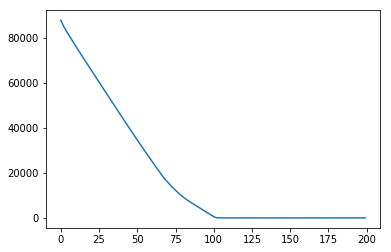

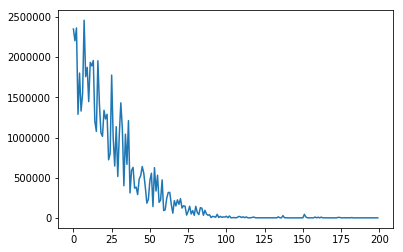

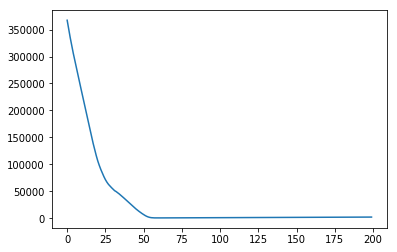

In [8]:
for model, history in models_histories.items():
    plt.plot(range(len(history)), history)
    plt.show()